# **Transformed Homogeneous 2D wave equation**:
# $ g_{xx} + g_{yy} + 16\pi^2g = 16\pi^2\cos\left[ 4\pi(x-y) \right] \qquad 0 < x < 1, \quad 0<y<1, \quad g ≡ g(x,y)$

## Boundary conditions (Dirichlet):
* $ g(x, 0) = \cos(4\pi x) \qquad 0 \leq x \leq 1$
* $ g(x, 1) = \cos(4\pi x) \qquad 0 \leq x \leq 1$
* $ g(0, y) = \cos(4\pi y) \qquad 0 \leq y \leq 1$
* $ g(1, y) = \cos(4\pi y) \qquad 0 \leq y \leq 1$

## *ANALYTICAL SOLUTION*
## $ g(x, y) = \cos\left[ 4\pi(x-y) \right] $

## *ORIGINAL SOLUTION*
## $ u(x, y) = g(x, y) - \cos(4\pi x)\cos(4\pi y) = \sin(4\pi x)\sin(4\pi y) $



# Imports

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Helpers

In [ ]:
def generate_random_numbers(N, dtype):
    random_numbers = torch.rand(N - 1, dtype=dtype)
    random_numbers = torch.cat([random_numbers, torch.tensor([1.0], dtype=dtype)])
    return random_numbers

## Data

In [ ]:
class Data():
  def __init__(self, device='cpu', dtype=torch.float32):
    super().__init__()
    self.device = device
    self.dtype = dtype

  # *** Create collocation points ***
  def sample_domain(self, Nx_domain, Ny_domain, is_test=False):
    # Random Grid
    x_domain = generate_random_numbers(Nx_domain, self.dtype)
    y_domain = generate_random_numbers(Ny_domain, self.dtype)
    XY_domain = torch.stack(torch.meshgrid(x_domain, y_domain)).reshape(2, -1).T.requires_grad_(True).to(self.device)
    print(XY_domain.shape)

    if is_test:
        return x_domain, y_domain, XY_domain

    return XY_domain

  # *** Boundary Conditions ***
  # 1. g(x,0) = cos(4πx)
  # 2. g(x,1) = cos(4πx)
  # 3. g(0,y) = cos(4πy)
  # 4. g(1,y) = cos(4πy)
  def sample_boundary(self, Nx_b, Ny_b):
    # Random boundary points
    self.h_x_b = 1e-4
    self.h_y_b = 1e-4
    x_b = torch.arange(0, 1+self.h_x_b, self.h_x_b)
    y_b = torch.arange(0, 1+self.h_y_b, self.h_y_b)
    # x_b = generate_random_numbers(Nx_b, self.dtype)
    # y_b = generate_random_numbers(Ny_b, self.dtype)

    bc1 = torch.stack(torch.meshgrid(x_b[0], y_b)).reshape(2,-1).T
    bc2 = torch.stack(torch.meshgrid(x_b[-1], y_b)).reshape(2,-1).T
    bc3 = torch.stack(torch.meshgrid(x_b, y_b[0])).reshape(2,-1).T
    bc4 = torch.stack(torch.meshgrid(x_b, y_b[-1])).reshape(2,-1).T

    XY_b = torch.cat([bc1, bc2, bc3, bc4]).to(self.device)
    print(f"shape(X_b) = {XY_b.shape}")

    gb_x = torch.cos(4*math.pi*x_b)
    gb_y = torch.cos(4*math.pi*y_b)
    g_b = torch.cat([gb_y, gb_y, gb_x, gb_x]).unsqueeze(1).to(self.device)
    print(f"shape(g_b) = {g_b.shape}")

    return XY_b, g_b

## Network

In [ ]:
class MLP(nn.Module):
  def __init__(self,
               layers,
               activation=nn.Tanh(),
               weight_init=None,
               bias_init=None,
               device='cpu'):

    super().__init__()
    self.n_layers = len(layers) - 1
    self.layers = layers
    self.activation = activation
    self.weight_init = weight_init
    self.bias_init = bias_init

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers - 1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))

    self.mlp = nn.Sequential(*dense_layers).to(device)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
    )

    if self.weight_init is not None:
        self.weight_init(dense_layer[0].weight)

    if self.bias_init is not None:
        self.bias_init(dense_layer[0].bias)

    dense_layer.add_module("activation", self.activation)
    return dense_layer

  def forward(self, x):
    return self.mlp(x)

## PINN

In [ ]:
class PINN():
    def __init__(self,
                 Nx_train, Ny_train,
                 Nx_b_train, Ny_b_train,
                 Nx_val, Ny_val,
                 Nx_test, Ny_test,
                 layers, activation,
                 scheduler_f, scheduler_p,
                 checkpoint_path,
                 device='cpu',
                 dtype=torch.float32):

        # Constants
        self.v = 16 * math.pi**2
        self.checkpoint_path = checkpoint_path
        self.device = device
        self.dtype = dtype

        # Some initializations
        self.epoch = 1

        # Create the data
        print("Creating the data...")
        self.data = Data(device, dtype)
        self.XY_train = self.data.sample_domain(Nx_train, Ny_train)
        self.XY_b_train, self.g_b_train = self.data.sample_boundary(Nx_b_train, Ny_b_train)
        self.XY_val = self.data.sample_domain(Nx_val, Ny_val)
        self.x_test, self.y_test, self.XY_test = self.data.sample_domain(Nx_test, Ny_test, is_test=True)

        # Define the model
        self.model = MLP(layers=layers,
                         activation=activation,
                         weight_init=lambda m: nn.init.xavier_normal_(m.data, nn.init.calculate_gain('tanh')),
                         bias_init=lambda m: nn.init.zeros_(m.data),
                         device=device)

        # Set the optimizers
        self.adam = torch.optim.Adam(self.model.parameters())

        self.lbfgs = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50_000,
            max_eval = 50_000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        # Set the Loss function
        self.criterion = torch.nn.MSELoss()


    def calculate_g(self, XY):
        return self.model(XY)


    def grad(self, output, input):
        return torch.autograd.grad(
                    output, input,
                    grad_outputs=torch.ones_like(output),
                    retain_graph=True,
                    create_graph=True
                )[0]


    def calculate_pde_residual(self, XY):
        # Forward pass
        g_hat = self.calculate_g(XY)

        # Calculate 1st and 2nd derivatives
        dg_dX = self.grad(g_hat, XY)
        dg_dXX = self.grad(dg_dX, XY)

        # Retrieve the partial gradients
        dg_dxx = dg_dXX[:, 0]
        dg_dyy = dg_dXX[:, 1]

        return dg_dxx + dg_dyy + self.v*g_hat.squeeze() - \
               self.v*torch.cos(4*math.pi*(XY[:, 0] - XY[:, 1]))


    def calculate_train_loss(self):
        # Calculate the boundary loss
        loss_b = self.criterion(self.calculate_g(self.XY_b_train), self.g_b_train)

        # Calculate the in-domain loss
        pde_res = self.calculate_pde_residual(self.XY_train)
        loss_pde = self.criterion(pde_res, torch.zeros_like(pde_res, dtype=self.dtype, device=self.device))

        # Calculate total loss
        loss = loss_b + loss_pde

        return loss_b, loss_pde, loss


    def calculate_val_loss(self):
        pde_res = self.calculate_pde_residual(self.XY_val)
        val_loss = self.criterion(pde_res, torch.zeros_like(pde_res, dtype=self.dtype, device=self.device))
        return val_loss


    def train_step(self):
        # "Zero" the gradients
        self.optimizer.zero_grad()

        # Get losses
        loss_b, loss_pde, loss = self.calculate_train_loss()
        self.val_loss = self.calculate_val_loss().cpu().item()

        # # Update scheduler
        # self.scheduler.step(self.val_loss)

        # Backpropagate the loss
        loss.backward()

        # print losses
        self.flag = 0
        self.checkpoint_and_print_losses(loss_b.cpu().item(),
                                         loss_pde.cpu().item(),
                                         loss.cpu().item())

        # Update "epoch"
        self.epoch = self.epoch + 1

        return loss


    def train(self, N_epochs_adam, print_every):
        self.print_every = print_every

        # Set model in training mode
        self.model.train()

        # Start with the "Adam" optimizer
        self.optimizer = self.adam

        # # Setting the scheduler
        # self.scheduler = ReduceLROnPlateau(self.optimizer,
        #                                    mode='min',
        #                                    factor=scheduler_f,
        #                                    patience=scheduler_p,
        #                                    verbose=True)

        for i in range(N_epochs_adam):
            self.optimizer.step(self.train_step)

        # Switch to "LBFGS" optimizer
        self.optimizer = self.lbfgs

        # # Setting the scheduler
        # self.scheduler = ReduceLROnPlateau(self.optimizer,
        #                                    mode='min',
        #                                    factor=scheduler_f,
        #                                    patience=scheduler_p,
        #                                    verbose=True)

        self.optimizer.step(self.train_step)


    def checkpoint_and_print_losses(self, loss_b, loss_pde, loss):
        if self.epoch == 1:
            self.best_val_loss = self.val_loss
            best_epoch = -1
            self.checkpoint()
            self.flag = 1
            print(f"Epoch: {self.epoch} | loss_b: {loss_b} | loss_pde: {loss_pde} | loss: {loss} | val_loss: {self.val_loss} - *Checkpoint*")
        else:
            if self.val_loss < self.best_val_loss:
                self.best_val_loss = self.val_loss
                best_epoch = self.epoch
                self.checkpoint()
                self.flag = 1
                if self.epoch % print_every == 0:
                    print(f"Epoch: {self.epoch} | loss_b: {loss_b} | loss_pde: {loss_pde} | loss: {loss} | val_loss: {self.val_loss} - *Checkpoint*")
            # elif self.epoch - best_epoch > self.patience:
            #     if self.epoch % print_every == 0:
            #         print(f"\nEarly stopping applied at epoch {self.epoch}.")
            #     break

        if (self.flag == 0) and (self.epoch % print_every == 0):
            print(f"Epoch: {self.epoch} | loss_b: {loss_b} | loss_pde: {loss_pde} | loss: {loss} | val_loss: {self.val_loss} - *Checkpoint*")

    def checkpoint(self):
        torch.save({
            "optimizer": self.optimizer.state_dict(),
            "model": self.model.state_dict()
        }, self.checkpoint_path)

# MAIN

In [ ]:
# Data
Nx_train = Ny_train = 200
Nx_b_train = Ny_b_train = 5_000
Nx_val = Ny_val = 100
Nx_test = Ny_test = 100

# Model
n_hidden_layers = 3
hidden_layer_size = 64
layers = [2] + n_hidden_layers * [hidden_layer_size] + [1]
activation = nn.Tanh()

# Scheduler
scheduler_f = 0.33
scheduler_p = 100

# Others
N_epochs_adam = 5_000
print_every = 100
checkpoint_path = "model.pth"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

# Create "PINN" object
pinn = PINN(Nx_train, Ny_train,
            Nx_b_train, Ny_b_train,
            Nx_val, Ny_val,
            Nx_test, Ny_test,
            layers, activation,
            scheduler_f, scheduler_p,
            checkpoint_path,
            device=device,
            dtype=dtype)

Creating the data...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([40000, 2])
shape(X_b) = torch.Size([40004, 2])
shape(g_b) = torch.Size([40004, 1])
torch.Size([10000, 2])
torch.Size([10000, 2])


In [ ]:
pinn.train(N_epochs_adam, print_every)

Epoch: 1 | loss_b: 1.353683590888977 | loss_pde: 35964.94140625 | loss: 35966.296875 | val_loss: 36159.859375 - *Checkpoint*
Epoch: 100 | loss_b: 0.5068180561065674 | loss_pde: 12329.6298828125 | loss: 12330.13671875 | val_loss: 12412.3505859375 - *Checkpoint*
Epoch: 200 | loss_b: 0.5153549909591675 | loss_pde: 12291.3701171875 | loss: 12291.8857421875 | val_loss: 12395.193359375 - *Checkpoint*
Epoch: 300 | loss_b: 0.5192880034446716 | loss_pde: 12262.0986328125 | loss: 12262.6181640625 | val_loss: 12393.27734375 - *Checkpoint*
Epoch: 400 | loss_b: 0.5236058235168457 | loss_pde: 12226.595703125 | loss: 12227.119140625 | val_loss: 12392.3125 - *Checkpoint*
Epoch: 500 | loss_b: 0.5284832715988159 | loss_pde: 12179.271484375 | loss: 12179.7998046875 | val_loss: 12390.46875 - *Checkpoint*
Epoch: 600 | loss_b: 0.5324820280075073 | loss_pde: 12098.56640625 | loss: 12099.0986328125 | val_loss: 12382.0625 - *Checkpoint*
Epoch: 700 | loss_b: 0.532486081123352 | loss_pde: 11932.69921875 | loss: 

# Results and Plots

In [ ]:
# pinn.x_test

In [ ]:
# # Get test data
# print("Getting test data")
# XY_test = pinn.XY_test.detach()    #.numpy().cpu()
# x_test = pinn.x_test
# y_test = pinn.y_test

h = 0.01
k = 0.01

x_test = torch.arange(0, 1, h)
y_test = torch.arange(0, 1, k)

XY_test = torch.stack(torch.meshgrid(x_test, y_test)).reshape(2,-1).T
XY_test = XY_test.to(device)

# Load best model
print("Loading best model...")
checkpoint = torch.load(checkpoint_path)
pinn.model.load_state_dict(checkpoint['model'])
# pinn.model.to("cpu")

# Inference
pinn.model.eval()
with torch.inference_mode():
    g_pred = pinn.model(XY_test).cpu().numpy()
    # g_pred = g_pred.reshape(len(x_test), len(y_test))

print(g_pred.shape)

# Real solution
g_real = np.zeros((len(x_test), len(y_test)))
for i, xi in enumerate(x_test):
    for j, yj in enumerate(y_test):
        g_real[i, j] = np.cos(4*np.pi*(xi - yj))

# Turn off 'requires_grad' and turn pytorch tensors into numpy arrays
x_test = x_test.cpu().numpy().flatten()
y_test = y_test.cpu().numpy().flatten()
g_pred = g_pred.flatten()
g_real = g_real.flatten()

# Calculate NMSE (Normalized Mean Square Error)
test_error = g_real - g_pred
test_nmse = np.linalg.norm(g_real - g_pred, 2) / np.linalg.norm(g_real, 2)
print(f'Test NMSE: {test_nmse}')


# test_df = pd.DataFrame(
#     {
#         'x_test': x_test,
#         'y_test': y_test,
#         'g_test_real': g_real,
#         'g_test_pinn': g_pred
#     }
# )
# test_df['abs_error'] = abs(test_df['g_test_real'] - test_df['g_test_pinn'])
# test_df.to_csv('Homogeneous_2d_wave_equation_results.csv', index=False)

Loading best model...
(10000, 1)
Test NMSE: 0.0005204888595479909


In [ ]:
u_real = np.zeros((len(x_test), len(y_test)))
cos_cos = np.zeros((len(x_test), len(y_test)))
for i, xi in enumerate(x_test):
    for j, yj in enumerate(y_test):
        u_real[i, j] = np.sin(4*np.pi*xi) * np.sin(4*np.pi*yj)
        cos_cos[i, j] = np.cos(4*np.pi*xi) * np.cos(4*np.pi*yj)

u_real = u_real.flatten()
cos_cos = cos_cos.flatten()

u_pred = g_pred - cos_cos

# Calculate NMSE (Normalized Mean Square Error)
test_error = u_real - u_pred
test_nmse = np.linalg.norm(u_real - u_pred, 2) / np.linalg.norm(u_real, 2)
print(f'Test NMSE: {test_nmse}')

Test NMSE: 0.00073603472084524


# Old plots

In [ ]:
# sns.set_style("white")
# plt.figure(figsize=(8, 6))
# sns.heatmap(g_pred, cmap='jet')
# plt.show()

In [ ]:
# sns.set_style("white")
# plt.figure(figsize=(8, 6))
# sns.heatmap(g_real, cmap='jet')
# plt.show()

In [ ]:
# sns.set_style("white")
# plt.figure(figsize=(8, 6))
# sns.heatmap(g_real-g_pred, cmap='jet')
# plt.show()

In [ ]:
# plt.plot(g_pred[:, 0])
# plt.plot(np.cos(4*np.pi*x_test))

# PLOTS

In [ ]:
# # Get x's where t=0
# t0_df = test_df[test_df['t_test'] == 0.0]
# x_t0 = t0_df['x_test'].to_numpy().flatten()

# # *** Check 1st Initial Condition ***
# u_t0_pinn = t0_df['u_test_pinn'].to_numpy()
# u_t0_real = np.sin(2*np.pi*x_t0)

# plt.figure()
# plt.plot(x_t0, u_t0_real, label='real')
# plt.plot(x_t0, u_t0_pinn, label='PINN')
# plt.xlabel("x")
# plt.ylabel("u")
# plt.title(r"$IC_1: u(x, 0) = sin(2\pi x)$")
# plt.legend()
# plt.show()


# # *** Check 2nd Initial Condition ***
# pos_t0 = np.where(t_test == 0.0)
# x_t0 = x_test[pos_t0]
# t0 = t_test[pos_t0]
# u_t_t0_pinn = u_test_pinn_t[pos_t0]
# u_t_t0_real = 8*np.sin(2*np.pi*x_t0) - 16*np.sin(4*np.pi*x_t0)

# plt.figure()
# plt.plot(x_t0, u_t_t0_real, label='real')
# plt.plot(x_t0, u_t_t0_pinn, label='PINN')
# plt.xlabel("x")
# plt.ylabel("u")
# plt.title(r"$IC_2: u_t(x, 0) = 8sin(2\pi x) - 16sin(4\pi x)$")
# plt.legend()
# plt.show()

In [ ]:
u_test_real_2D = u_real.reshape(len(x_test), len(y_test))
u_test_pinn_2D = u_pred.reshape(len(x_test), len(y_test))
test_error_2D = test_error.reshape(len(x_test), len(y_test))

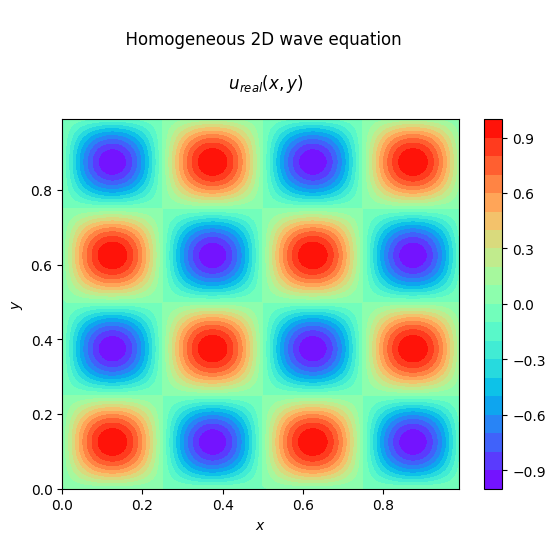

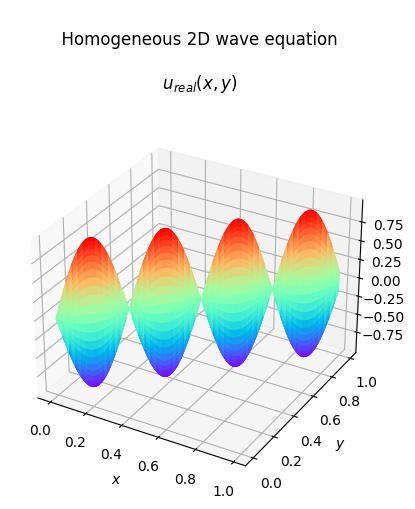

In [ ]:
def plot_real(x,y,F):
  F_xt = F
  fig,ax=plt.subplots(1,1)

  cp = ax.contourf(x,y, F_xt,20,cmap="rainbow")
  fig.colorbar(cp)
  ax.set_title(r'''
  Homogeneous 2D wave equation

  $ u_{real}(x,y) $
  ''')
  ax.set_xlabel(r'$x$')
  ax.set_ylabel(r'$y$')
  plt.show()

  ax = plt.axes(projection='3d')
  ax.plot_surface(x, y, F_xt,cmap="rainbow")
  ax.set_title(r'''
  Homogeneous 2D wave equation

  $ u_{real}(x,y) $
  ''')
  ax.set_xlabel(r'$x$')
  ax.set_ylabel(r'$y$')
  plt.show()


plot_real(x_test, y_test, u_test_real_2D)

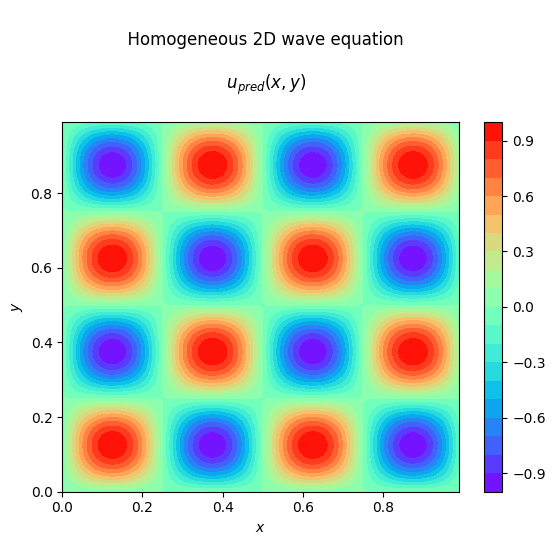

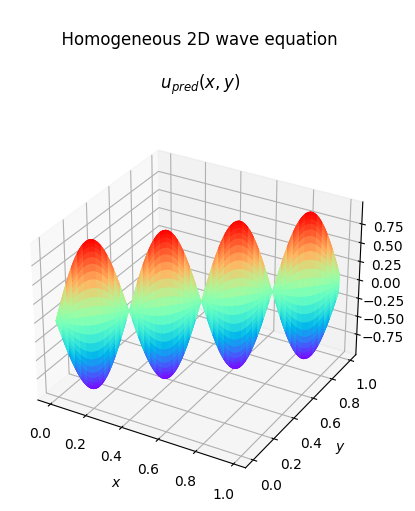

In [ ]:
def plot_pred(x,y,F):
  F_xt = F
  fig,ax=plt.subplots(1,1)

  cp = ax.contourf(x,y, F_xt,20,cmap="rainbow")
  fig.colorbar(cp)
  ax.set_title(r'''
  Homogeneous 2D wave equation

  $ u_{pred}(x,y) $
  ''')
  ax.set_xlabel(r'$x$')
  ax.set_ylabel(r'$y$')
  plt.show()

  ax = plt.axes(projection='3d')
  ax.plot_surface(x, y, F_xt,cmap="rainbow")
  ax.set_title(r'''
  Homogeneous 2D wave equation

  $ u_{pred}(x,y) $
  ''')
  ax.set_xlabel(r'$x$')
  ax.set_ylabel(r'$y$')
  plt.show()


plot_pred(x_test, y_test, u_test_pinn_2D)

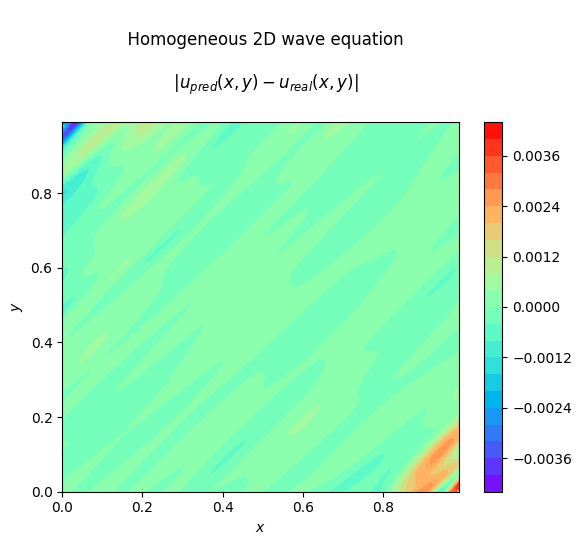

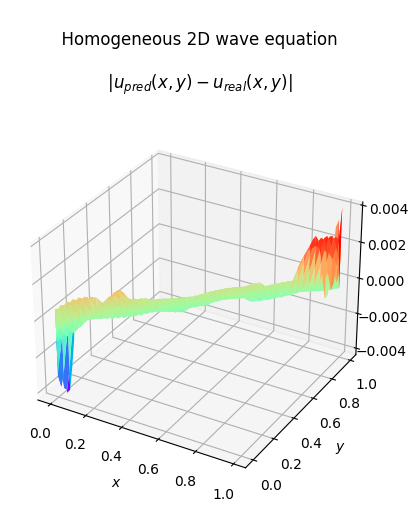

In [ ]:
def plot_abs_diff(x,y,F):
  F_xt = F
  fig,ax=plt.subplots(1,1)

  cp = ax.contourf(x,y, F_xt,20,cmap="rainbow")
  fig.colorbar(cp)
  ax.set_title(r'''
  Homogeneous 2D wave equation

  $ |u_{pred}(x,y) - u_{real}(x,y)|$
  ''')
  ax.set_xlabel(r'$x$')
  ax.set_ylabel(r'$y$')
  plt.show()

  ax = plt.axes(projection='3d')
  ax.plot_surface(x, y, F_xt,cmap="rainbow")
  ax.set_title(r'''
  Homogeneous 2D wave equation

  $ |u_{pred}(x,y) - u_{real}(x,y)|$
  ''')
  ax.set_xlabel(r'$x$')
  ax.set_ylabel(r'$y$')
  plt.show()


plot_abs_diff(x_test, y_test, test_error_2D)